In [3]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
data_path = 'EMG_data_for_gestures-master/'
# data_path = '/content/gdrive/MyDrive/' + data_path
num_participants = 36

def retrieve_data(participant_range = (0,30), 
                  additional_participants = [], # For adding participants out of the range
                  data_path = data_path):
    participants = list(additional_participants)
    by_participant_dfs = list()
    for i in range(*participant_range):
        dir_string = str(i+1)
        if i <= 8:
            dir_string = '0' + dir_string
        participants.append(dir_string)
    
    for participant in participants:
        path = data_path + participant
        files = [f for f in listdir(path) if isfile(join(path, f))]
        participant_dfs = []
        for f in files:
            df = pd.read_csv(path + '/' + f, sep='\t')
            df['Participant'] = participant
            participant_dfs.append(df)            

        by_participant_dfs.append(pd.concat(participant_dfs))

    full_df = pd.concat(by_participant_dfs)
    
    # Fix the index
    num_rows = len(full_df.index)
    new_index = np.arange(0,num_rows)
    return full_df.set_index(new_index), participants

In [5]:
train_df, participants_train = retrieve_data()
test_df, participants_test = retrieve_data(participant_range = (30,36))
display(train_df)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,Participant
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,01
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,01
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,01
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0,01
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0,01
...,...,...,...,...,...,...,...,...,...,...,...
3579387,72888,-0.00002,-0.00002,-0.00002,-0.00008,0.00000,-0.00002,-0.00002,-0.00001,0,30
3579388,72889,-0.00002,-0.00002,-0.00002,-0.00008,0.00000,-0.00002,-0.00002,-0.00001,0,30
3579389,72890,-0.00002,-0.00002,-0.00002,-0.00008,0.00000,-0.00002,-0.00002,-0.00001,0,30
3579390,72891,-0.00005,-0.00002,0.00001,-0.00001,-0.00002,0.00003,0.00001,-0.00001,0,30


## Preprocessing
We will use the filteremg function from lab4, as well as a fast fourier transform on each window

In [6]:
import scipy as sp
import scipy.signal

def filteremg(emg, low_pass=10, sfreq=1000, high_band=20, low_band=450):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/(sfreq/2)
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [7]:
channels = ['channel' + str(i) for i in range(1,9)]
train_df[channels] = train_df[channels].apply(filteremg)
test_df[channels] = test_df[channels].apply(filteremg)

In [8]:
# Windowed DF

# Returns a list of windowed for each participants dataframes
def generate_windowed_dfs(df, participants, window_size, stride):
    windows = []
    grouped_df = df.groupby(['Participant'])
    for participant in participants:
        p_df = grouped_df.get_group(participant)
        dfs = sliding_window(p_df, window_size=window_size, stride=stride)
        windows.extend(dfs)
    return windows

def sliding_window(df, window_size, stride, fs=1000): # Do sampling based on num of rows

    # This function only works for continous dfs (not multiple combined participant dfs)
    dfs = []
    df_cop = df.copy() # create copy of dataframe
    starting_index = df_cop.index[0]
    ending_index = int(df_cop.index[0] + fs*window_size)
    while ending_index <= df_cop.index[-1]:
        windowed_df = df_cop.loc[(df_cop.index >= starting_index) & (df_cop.index <= ending_index)]
        dfs.append(windowed_df)
        starting_index = int(starting_index + fs*stride)
        ending_index = int(ending_index + fs*stride)
    return dfs


train_windows = generate_windowed_dfs(train_df, participants_train, 2, 0.5) # Do 1 s strides
test_windows = generate_windowed_dfs(test_df, participants_test, 2, 0.5)

In [9]:
display(train_windows[0].shape)
display(train_windows[0]['channel1'].values)

(2001, 11)

array([2.45789188e-06, 2.63861282e-06, 2.81942149e-06, ...,
       1.52379223e-05, 1.53573062e-05, 1.54628037e-05])

In [26]:
from scipy import signal
from scipy.stats import moment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from math import *
from more_itertools import distinct_combinations
# From https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

def extract_channel_features(channel_data, fs): # Channel data should be a 1D array
    chan_feats = dict()
    # Time domain features
    chan_feats['mean'] = np.mean(channel_data)
    chan_feats['variance'] = np.var(channel_data)
    chan_feats['rms'] = np.sqrt(np.mean(channel_data**2))
    chan_feats['second_moment'] = moment(channel_data, moment=2)
    chan_feats['mav'] = np.sqrt(np.mean(abs(channel_data)))
    
    # Calculate Willison Amplitude and zero crossings
    chan_max = np.amax(channel_data)
    thresh = 0.3 * chan_max
    will_amp = 0
    zcrossings = 0
    for i in range(len(channel_data) - 1):
        if abs(channel_data[i] - channel_data[i+1]) > thresh:
            will_amp += 1
        if (channel_data[i] / channel_data[i+1]) < 0:
            zcrossings += 1
            
    chan_feats['wamp'] = will_amp
    chan_feats['zcrossings'] = zcrossings
    
    
    # Calculate energy so we can calculate the energy later on.
    energy = np.sum(channel_data**2)
    
    # PSD features
    f, P = signal.welch(channel_data, fs, 'flattop', nperseg=2001, scaling='spectrum')
    max_ind = np.argmax(P)
    chan_feats['peak_frequency'] = f[max_ind]
    chan_feats['power_max'] = np.sqrt(P[max_ind])
    # chan_feats['power_mean'] = np.mean(P)

    # Frequency domain features
    N = 2001
    T = N / 1000
    yf = fft(channel_data)
    yf = 2.0/N * np.abs(yf[0:N//2])
    xf = fftfreq(N, T)[:N//2]
    ind = np.argmax(yf)
    chan_feats['max_freq'] = xf[ind]
    chan_feats['fft_peak'] = np.sqrt(yf[ind])

    t_values, autocorr_values = get_autocorr_values(channel_data, T, N, fs)
    min_ind = np.argmin(autocorr_values)
    autocorr_values = autocorr_values[min_ind:]
    ind = np.argmax(autocorr_values)
    chan_feats['max_corr'] = autocorr_values[ind]
    chan_feats['corr_time'] = t_values[ind]
    
    return chan_feats, energy
    
def extract_window_features(df, channels, fs=1000):
    window_feats = dict()
    df_cop = df.copy()
    energies = list()
    for chan in channels:
        chan_data =  df[chan].values
        chan_feats, energy = extract_channel_features(chan_data, fs)
        energies.append(energy)
        keys = list(chan_feats.keys())
        for key in keys:
            window_feats[chan + '_' + key] = chan_feats[key]
            
    norm_value = np.sum(df['channel1'].values)
    ind_combs = list(distinct_combinations([0,1,2,3,4,5,6,7], 2))
    for ind in ind_combs:
        first = ind[0]
        second = ind[1]
        window_feats[str(first) + '_' + str(second) + '_energy_ration'] = (energies[first] / energies[second]) / (energies[second] / norm_value)
                
    return pd.DataFrame(window_feats, index=[0])

## Format data for LSTM

In [24]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from scipy.stats import mode

def format_data_for_lstm(windows, min_confidence=0.5): # Confidence level will cause any windows 
    channels = ['channel' + str(i + 1) for i in range(8)] # where the mode count is less than 0.7 * size                                                          # To be thrown out
    # Put windowed dfs into a 3d array                    # to be thrown out
    X = list()
    y = list()
    for window in windows:
        df = window.copy()
#         data = np.array(df[[col for col in df.columns if col in channels]])
        # We want a label for each windowed set of data
        labels = pd.to_numeric(df['class'].values)
        mode_data = mode(labels)
        m = mode_data[0][0]
        count = mode_data[1][0]
        confidence = float(count) / float(df.shape[0])
        if confidence < min_confidence:
            continue # Throw out dataset if more than 30% of it is unmarked
        if m == 7: # Throw out window if it is 7, which is not a class all participants use
            continue
        
        feat_df = extract_window_features(window,channels)
        data = feat_df.values
        
        y.append(m)
        X.append(data)
        
    X = np.array(X)
    y = np.array(y)
    y = to_categorical(y)
    return X, y

# print(X_train.shape)
# print(X_test.shape)
# channel_scalers = {}
# for i in range(X_train.shape[2]):
#     channel_scalers[i] = StandardScaler()
#     X_train[:, :, i] = channel_scalers[i].fit_transform(X_train[:, :, i])
#     X_test[:, :, i] = channel_scalers[i].transform(X_test[: , :, i])
     
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)


In [27]:
X_train, y_train = format_data_for_lstm(train_windows)
X_test, y_test = format_data_for_lstm(test_windows)
display(X_train.shape, y_train.shape)
display(y_train)

(7027, 1, 132)

(7027, 7)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model
Now we will define our model

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy

model = keras.Sequential()
model.add(LSTM(units=1024,
              dropout=0.3,
              recurrent_dropout=0.3,
              activation = 'tanh', 
              name = 'layer0', 
              return_sequences=False, 
              input_shape=(1, 132)))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, name='output', activation='softmax')) # Need activation function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def pre_process_data(data, participants):
    channels = ['channel' + str(i + 1) for i in range(8)] # where the mode count is less than 0.7 * size                                                          # To be thrown out
    data[channels] = data[channels].apply(filteremg)
    windows = generate_windowed_dfs(data, participants, 2, 0.5)
    X, y = format_data_for_lstm(windows)
    return X, y

def validate_model(y_pred, y_test):
    y_pred_c = np.argmax(y_pred, axis=1)
    y_test_c = np.argmax(y_test, axis=1)
    # display(y_pred_c, y_test_c)
    cm = confusion_matrix(y_test_c, y_pred_c)
    display(cm)
    display(accuracy_score(y_pred_c, y_test_c))

In [35]:
# Train model
history = model.fit(X_train, y_train, epochs = 200, batch_size=32, validation_split=0.1)

Epoch 1/200
198/198 [==============================] - 14s 63ms/step - loss: 1.3054 - categorical_accuracy: 0.5455 - val_loss: 0.9978 - val_categorical_accuracy: 0.6458
Epoch 2/200
198/198 [==============================] - 12s 61ms/step - loss: 0.9655 - categorical_accuracy: 0.6376 - val_loss: 1.0538 - val_categorical_accuracy: 0.6373
Epoch 3/200
198/198 [==============================] - 13s 65ms/step - loss: 0.9738 - categorical_accuracy: 0.6294 - val_loss: 1.0496 - val_categorical_accuracy: 0.6358
Epoch 4/200
198/198 [==============================] - 12s 63ms/step - loss: 0.9535 - categorical_accuracy: 0.6388 - val_loss: 1.0468 - val_categorical_accuracy: 0.6529
Epoch 5/200
198/198 [==============================] - 13s 64ms/step - loss: 0.9306 - categorical_accuracy: 0.6410 - val_loss: 1.0864 - val_categorical_accuracy: 0.6430
Epoch 6/200
198/198 [==============================] - 12s 63ms/step - loss: 0.9187 - categorical_accuracy: 0.6421 - val_loss: 1.0600 - val_categorical_acc

198/198 [==============================] - 11s 56ms/step - loss: 0.8356 - categorical_accuracy: 0.6499 - val_loss: 1.0195 - val_categorical_accuracy: 0.6486
Epoch 50/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8550 - categorical_accuracy: 0.6427 - val_loss: 1.0856 - val_categorical_accuracy: 0.6316
Epoch 51/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8366 - categorical_accuracy: 0.6492 - val_loss: 1.0194 - val_categorical_accuracy: 0.6430
Epoch 52/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8478 - categorical_accuracy: 0.6387 - val_loss: 1.0383 - val_categorical_accuracy: 0.6458
Epoch 53/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8451 - categorical_accuracy: 0.6498 - val_loss: 0.9878 - val_categorical_accuracy: 0.6558
Epoch 54/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8516 - categorical_accuracy: 0.6419 - val_loss: 1.0316 - val_categorical_accuracy: 

198/198 [==============================] - 11s 56ms/step - loss: 0.8476 - categorical_accuracy: 0.6413 - val_loss: 1.1239 - val_categorical_accuracy: 0.6529
Epoch 98/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8386 - categorical_accuracy: 0.6607 - val_loss: 1.0548 - val_categorical_accuracy: 0.6458
Epoch 99/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8259 - categorical_accuracy: 0.6610 - val_loss: 1.0777 - val_categorical_accuracy: 0.6515
Epoch 100/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8348 - categorical_accuracy: 0.6464 - val_loss: 0.9964 - val_categorical_accuracy: 0.6629
Epoch 101/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8494 - categorical_accuracy: 0.6415 - val_loss: 1.0333 - val_categorical_accuracy: 0.6486
Epoch 102/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8535 - categorical_accuracy: 0.6391 - val_loss: 1.0899 - val_categorical_accurac

198/198 [==============================] - 11s 57ms/step - loss: 0.8357 - categorical_accuracy: 0.6438 - val_loss: 1.0687 - val_categorical_accuracy: 0.6472
Epoch 146/200
198/198 [==============================] - 11s 57ms/step - loss: 0.8380 - categorical_accuracy: 0.6451 - val_loss: 1.1052 - val_categorical_accuracy: 0.6543
Epoch 147/200
198/198 [==============================] - 11s 57ms/step - loss: 0.8275 - categorical_accuracy: 0.6478 - val_loss: 1.0880 - val_categorical_accuracy: 0.6486
Epoch 148/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8243 - categorical_accuracy: 0.6513 - val_loss: 1.0351 - val_categorical_accuracy: 0.6586
Epoch 149/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8141 - categorical_accuracy: 0.6553 - val_loss: 1.1139 - val_categorical_accuracy: 0.6458
Epoch 150/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8289 - categorical_accuracy: 0.6435 - val_loss: 1.0920 - val_categorical_accur

Epoch 193/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8340 - categorical_accuracy: 0.6478 - val_loss: 1.1016 - val_categorical_accuracy: 0.6486
Epoch 194/200
198/198 [==============================] - 11s 55ms/step - loss: 0.8160 - categorical_accuracy: 0.6544 - val_loss: 1.0047 - val_categorical_accuracy: 0.6572
Epoch 195/200
198/198 [==============================] - 11s 53ms/step - loss: 0.8104 - categorical_accuracy: 0.6419 - val_loss: 1.1032 - val_categorical_accuracy: 0.6543
Epoch 196/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8180 - categorical_accuracy: 0.6505 - val_loss: 1.0610 - val_categorical_accuracy: 0.6515
Epoch 197/200
198/198 [==============================] - 11s 56ms/step - loss: 0.8105 - categorical_accuracy: 0.6535 - val_loss: 1.1011 - val_categorical_accuracy: 0.6558
Epoch 198/200
198/198 [==============================] - 11s 57ms/step - loss: 0.8041 - categorical_accuracy: 0.6618 - val_loss: 1.0936 - val_cat

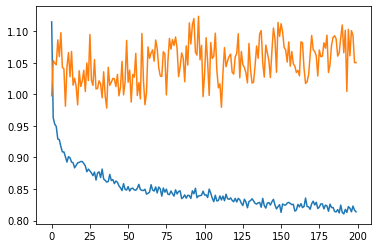

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [37]:
# Evaluate model
score = model.evaluate(X_train, y_train)
display(score)

220/220 [==============================] - 3s 12ms/step - loss: 0.7986 - categorical_accuracy: 0.6624


[0.7985568046569824, 0.6624448299407959]

In [38]:
test_score = model.evaluate(X_test, y_test)
display(test_score)

41/41 [==============================] - 1s 13ms/step - loss: 0.9100 - categorical_accuracy: 0.6315


[0.9099583029747009, 0.6314572095870972]

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
display(X_test.shape)
y_pred = model.predict(X_test)
y_pred_c = np.argmax(y_pred, axis=1)
y_test_c = np.argmax(y_test, axis=1)
# display(y_pred_c, y_test_c)
cm = confusion_matrix(y_test_c, y_pred_c)
display(cm)
display(accuracy_score(y_pred_c, y_test_c))

(1297, 1, 132)

array([[747,  12,   1,  18,   1,   5,  25],
       [ 60,  25,   0,   0,   0,   0,   0],
       [ 77,   0,   1,   0,   0,   0,   0],
       [ 50,   0,   0,  28,   0,   0,   0],
       [ 81,   0,   0,   0,   0,   0,   3],
       [ 74,   0,   0,   0,   0,   7,   0],
       [ 71,   0,   0,   0,   0,   0,  11]])

0.6314572089437163

In [84]:
model.save('Models/lstm_model')

INFO:tensorflow:Assets written to: Models/lstm_model/assets


In [40]:
test_data, participants = retrieve_data(participant_range=(0,30))
train_data, train_participants = retrieve_data(participant_range=(30,36))
X_train, y_train = pre_process_data(test_data, participants)
X_test, y_test = pre_process_data(train_data, train_participants)

In [41]:
display(X_train.shape, y_train.shape)

(7027, 1, 132)

(7027, 7)

In [99]:
count = 0
for row in y_train:
    gest = np.argmax(row)
    if gest == 0:
        count += 1
        
display(count / len(y_train))

0.6418101608083108

## Create, Train and Test the Second Model
The second model uses Independent Recurrent cells as proposed by this paper 
https://arxiv.org/abs/1803.04831

In [43]:
from ind_rnn import RNN, IndRNNCell
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy

model = keras.Sequential()
cells = [IndRNNCell(256), IndRNNCell(256)] # Default activation is ReLU
model.add(RNN(cells, input_shape = (1,132)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, name='output', activation='softmax')) # Need activation function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [44]:
history_2 = model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_split=0.1)

Epoch 1/100
198/198 [==============================] - 2s 5ms/step - loss: 71913.3801 - categorical_accuracy: 0.5070 - val_loss: 1.7828 - val_categorical_accuracy: 0.6430
Epoch 2/100
198/198 [==============================] - 1s 3ms/step - loss: 106.8745 - categorical_accuracy: 0.6402 - val_loss: 1.6348 - val_categorical_accuracy: 0.6430
Epoch 3/100
198/198 [==============================] - 1s 4ms/step - loss: 222.2139 - categorical_accuracy: 0.6434 - val_loss: 1.5216 - val_categorical_accuracy: 0.6430
Epoch 4/100
198/198 [==============================] - 1s 5ms/step - loss: 385.6320 - categorical_accuracy: 0.6277 - val_loss: 1.4381 - val_categorical_accuracy: 0.6430
Epoch 5/100
198/198 [==============================] - 1s 4ms/step - loss: 33.3959 - categorical_accuracy: 0.6342 - val_loss: 1.3811 - val_categorical_accuracy: 0.6430
Epoch 6/100
198/198 [==============================] - 1s 6ms/step - loss: 2.5121 - categorical_accuracy: 0.6498 - val_loss: 1.3442 - val_categorical_accu

Epoch 50/100
198/198 [==============================] - 1s 3ms/step - loss: 1.2837 - categorical_accuracy: 0.6462 - val_loss: 1.2913 - val_categorical_accuracy: 0.6430
Epoch 51/100
198/198 [==============================] - 1s 3ms/step - loss: 1.3158 - categorical_accuracy: 0.6327 - val_loss: 1.2913 - val_categorical_accuracy: 0.6430
Epoch 52/100
198/198 [==============================] - 1s 3ms/step - loss: 1.2939 - categorical_accuracy: 0.6419 - val_loss: 1.2913 - val_categorical_accuracy: 0.6430
Epoch 53/100
198/198 [==============================] - 1s 3ms/step - loss: 1.2845 - categorical_accuracy: 0.6459 - val_loss: 1.2913 - val_categorical_accuracy: 0.6430
Epoch 54/100
198/198 [==============================] - 1s 3ms/step - loss: 1.3062 - categorical_accuracy: 0.6368 - val_loss: 1.2914 - val_categorical_accuracy: 0.6430
Epoch 55/100
198/198 [==============================] - 1s 3ms/step - loss: 1.2770 - categorical_accuracy: 0.6491 - val_loss: 1.2913 - val_categorical_accuracy:

Epoch 99/100
198/198 [==============================] - 1s 4ms/step - loss: 1.3233 - categorical_accuracy: 0.6296 - val_loss: 1.2914 - val_categorical_accuracy: 0.6430
Epoch 100/100
198/198 [==============================] - 1s 4ms/step - loss: 1.3032 - categorical_accuracy: 0.6380 - val_loss: 1.2913 - val_categorical_accuracy: 0.6430


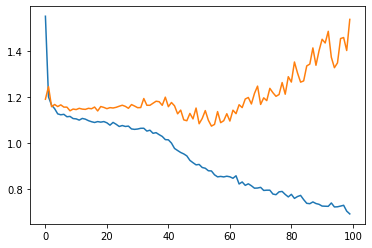

In [96]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

In [97]:
# Train score
score = model.evaluate(X_train, y_train)
display(score)

220/220 [==============================] - 0s 2ms/step - loss: 0.6847 - categorical_accuracy: 0.7528


[0.6846734285354614, 0.7528105974197388]

In [98]:
test_score = model.evaluate(X_test, y_test)
display(test_score)

41/41 [==============================] - 0s 2ms/step - loss: 1.3205 - categorical_accuracy: 0.6237


[1.3205066919326782, 0.6237471103668213]

In [64]:
y_pred = model.predict(X_test)
validate_model(y_pred, y_test)

array([[691,  27,  20,  30,   8,  11,  22],
       [ 54,  28,   0,   3,   0,   0,   0],
       [ 27,   0,  20,  16,   1,   1,  13],
       [ 30,   1,  10,  20,   0,   2,  15],
       [ 28,   0,  10,   1,  33,   8,   4],
       [ 49,   0,   1,   0,  14,  13,   4],
       [ 30,   0,  15,  19,   0,   0,  18]])

0.6345412490362374